## XResNet ImageWoof

https://colab.research.google.com/github/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/04_ImageWoof.ipynb#scrollTo=p88U6dmAgEL4

https://jwuphysics.github.io/blog/galaxies/astrophysics/deep%20learning/computer%20vision/fastai/2020/05/26/training-a-deep-cnn.html

In [1]:
from fastai.vision.all import *
import pandas as pd

In [2]:
path = untar_data(URLs.IMAGEWOOF)

In [3]:
path

Path('/jet/.fastai/data/imagewoof2')

In [4]:
# set of transforms
tfms = [[PILImage.create], [parent_label, Categorize()]]
item_tfms = [ToTensor(), Resize(128)]
batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35),
              IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

In [5]:
items = get_image_files(path)

In [6]:
len(items)

12954

In [7]:
path.ls()

(#2) [Path('/jet/.fastai/data/imagewoof2/val'),Path('/jet/.fastai/data/imagewoof2/train')]

In [8]:
split_idx = GrandparentSplitter(valid_name='val')(items)

### Build Dataset

In [9]:
dsets = Datasets(items, tfms, splits = split_idx)

In [10]:
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)

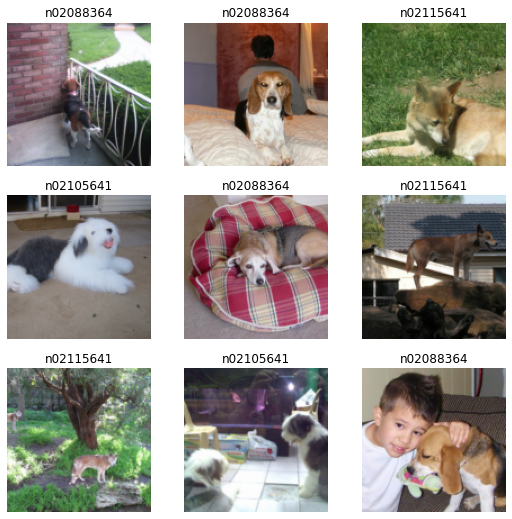

In [11]:
dls.show_batch()

In [12]:
lbl_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

In [13]:
tfms = [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize()]]

In [14]:
dsets = Datasets(items, tfms, splits=split_idx)

In [15]:
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)

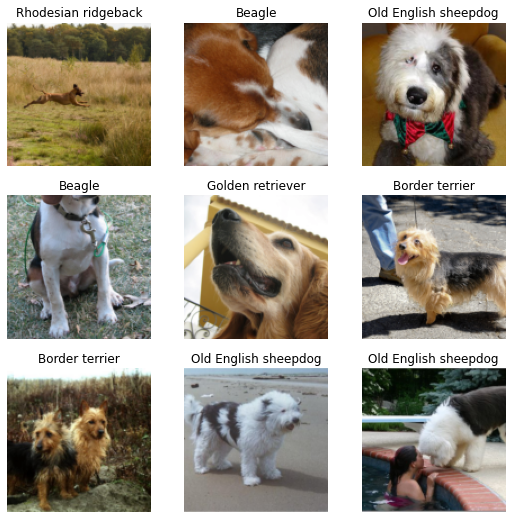

In [16]:
dls.show_batch()

### The Architecture and the new Implementations
 - XResNet - Based on the Bag of Tricks for Resnet paper (https://arxiv.org/abs/1812.01187)
 - Mish - A new activation function that has shown fantastic results (https://arxiv.org/abs/1908.08681v1)
 - Ranger - A new optimizer function based on two seperate papers:
     - On the Varience of the Adaptive Learning rate and Beyond, RAdam (https://arxiv.org/abs/1908.03265)
     - Lookahead Optimizer: k steps forward, 1 step back (https://arxiv.org/abs/1907.08610)
 - Self-Attention - Bringing in ideas from GAN's into image classification (Incorportated by Seb) (https://arxiv.org/abs/1805.08318)
 - MaxBlurPool - Better generalization (https://arxiv.org/pdf/1904.11486.pdf)
 - Flatten + Anneal Scheduling - Mikhail Grankin
 - Label Smoothing Cross Entropy - A threshold base (were you close) rather than yes or no (https://arxiv.org/abs/1906.11567)

All of these ideas live in the library (except Dialated Convolutions for now). But where? Let's walk through it

In [17]:
# XResNet50
arch = xresnet50(pretrained=False)

In [18]:
arch = xresnet50(pretrained=False, act_cls=Mish)

In [19]:
arch[0]

ConvLayer(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Mish()
)

In [20]:
arch[-1]

Linear(in_features=2048, out_features=1000, bias=True)

In [21]:
#Self-Attention
arch = xresnext50(pretrained=False, act_cls=Mish, sa=True)

In [22]:
#MaxBlurPool
# Adopted from 
# https://discuss.pytorch.org/t/how-can-i-replace-an-intermediate-layer-in-a-pre-trained-network/3586/7
import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model

In [23]:
net = xresnet50(pretrained=False, act_cls=Mish, sa=True, n_out=10)

In [24]:
net = convert_MP_to_blurMP(net, nn.MaxPool2d)

In [25]:
net._modules.items()

odict_items([('0', ConvLayer(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Mish()
)), ('1', ConvLayer(
  (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Mish()
)), ('2', ConvLayer(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Mish()
)), ('3', MaxBlurPool2d()), ('4', Sequential(
  (0): ResBlock(
    (convpath): Sequential(
      (0): ConvLayer(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (1): ConvLayer(
        (0): Conv2d(64, 64, kernel_size=

### Ranger + Fit-Flat-Cosine

In [26]:
opt_func = ranger

In [27]:
# cell above is the same as:
def opt_func(ps, lr=defaults.lr): return Lookahead(RAdam(ps, lr=lr))

In [28]:
opt_func = ranger

In [46]:
# Label Smoothing Cross Entropy as our loss
learn = Learner(dls, model=net, loss_func=LabelSmoothingCrossEntropy(), metrics=[top_k_accuracy, accuracy])

/jet/var/python/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=1.0964781722577754e-06)

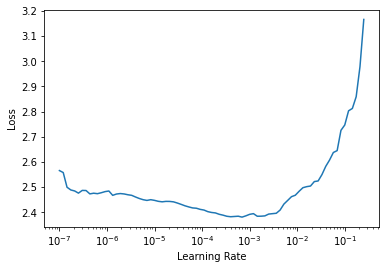

In [47]:
learn.lr_find()

### One-Cycle vs Fit-Flat-Cosine

In [48]:
from fastai.test_utils import synth_learner

In [69]:
synth = synth_learner(suggestion=True)  #synth_learner which is a simple Learner training a linear regression model.
                         # For quick testing of the training loop and Callbacks

In [70]:
synth.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,10.417623,9.062661,00:00


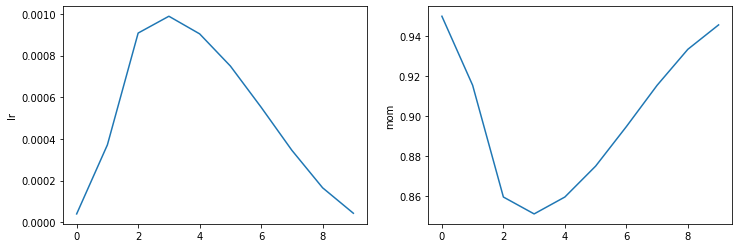

In [71]:
synth.recorder.plot_sched()

In [72]:
synth.fit_flat_cos(1, pct_start=0.72)

epoch,train_loss,valid_loss,time
0,8.681873,6.530555,00:00


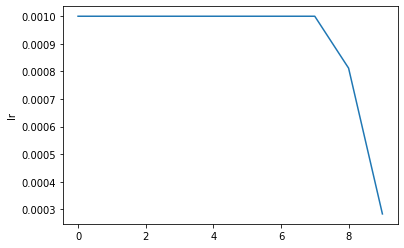

In [73]:
synth.recorder.plot_sched()

In [74]:
# Train the model
learn.fit_one_cycle(5, 4e-3)

epoch,train_loss,valid_loss,top_k_accuracy,accuracy,time
0,2.196342,3.397616,0.670654,0.175108,17:00
1,1.915098,2.021817,0.845253,0.346908,16:59
2,1.670134,1.767663,0.911428,0.452787,17:19
3,1.478658,1.486579,0.942225,0.573937,17:10
4,1.326845,1.327726,0.950624,0.650293,17:21


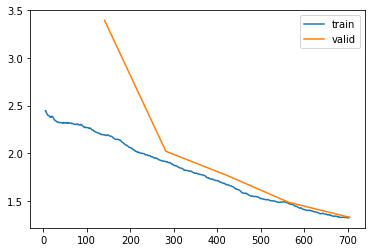

In [76]:
learn.recorder.plot_loss()
#plt.ylim(0, 0.4);

### Test Time Augmentation

Depending on the dataset, test time augmentation can result in dramatic improvements in accuracy. It does not change the time required to train at all, but will increase the amount of time required for validation or inference by the number of test-time-augmented images requested. By default, fastai will use the unaugmented center crop image plus four randomly augmented images.

You can pass any DataLoader to fastai's tta method; by default, it will use your validation set

As we can see, using TTA gives us good a boost in performance, with no additional training required. However, it does make inference slower—if you're averaging five images for TTA, inference will be five times slower.

https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb

In [77]:
preds, trues = learn.tta()

In [79]:
preds.shape  # np.array(preds.view(-1)) has shape [3929,] - flatten

torch.Size([3929, 10])

In [81]:
np.array(preds.view(-1))

array([0.03416751, 0.01471593, 0.04789241, ..., 0.23785791, 0.04793053,
       0.02652641], dtype=float32)

In [103]:
# sum(torch.argmax(preds, 1)==trues)   -- the number of write predicted values
# this number is tensor format, it should be converted to numpy for devision
accur = (sum(torch.argmax(preds, 1)==trues)).detach().cpu().numpy()/len(trues)
accur

0.6569101552557903